<a href="https://colab.research.google.com/github/fareesah28/INM705-CW/blob/main/MariumColabFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DINOv2 + Transformer**

---





*Before running the first code block, please *download the file from the following link and upload it to your Google Drive:**

https://drive.google.com/file/d/145OHbfMAaot25bgx2tDRsiIXvOKLvezi/view?usp=sharing

# **Stage 1: Data Loading & Extraction**
(Mount Drive, unzip dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/data_trimmed_clean.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

# **Stage 2: Dataset Restructuring**
(Organize frames into folders per video)

In [ ]:
import os
import shutil
from collections import defaultdict


def extract_video_id(filename):
    """
    Extracts the video ID by removing the frame suffix (assumes last underscore + digits is the frame number).
    For example:
        Normal_Videos_003_x264_0.png → Normal_Videos_003_x264
        Assault_001_frame_010.png → Assault_001
    """
    parts = filename.rsplit("_", 1)
    return parts[0] if len(parts) == 2 else filename.split("_frame")[0]


def restructure_dataset(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)


    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if not os.path.isdir(class_path):
            continue


        print(f"Processing class: {class_name}")
        video_frame_dict = defaultdict(list)


        for fname in os.listdir(class_path):
            if not fname.endswith('.png'):
                continue


            video_id = extract_video_id(fname)
            video_frame_dict[video_id].append(fname)


        for video_id, frames in video_frame_dict.items():
            video_folder_path = os.path.join(dst_dir, class_name, video_id)
            os.makedirs(video_folder_path, exist_ok=True)


            for frame in frames:
                src = os.path.join(class_path, frame)
                dst = os.path.join(video_folder_path, frame)
                shutil.copy2(src, dst)


    print(f"Done restructuring: {src_dir} → {dst_dir}\n")


train_dir = "/content/data_trimmed/Train"
test_dir = "/content/data_trimmed/Test"


train_dst = "/content/data_trimmed_restructured/Train"
test_dst = "/content/data_trimmed_restructured/Test"


# Run restructuring
restructure_dataset(train_dir, train_dst)
restructure_dataset(test_dir, test_dst)


Processing class: Arrest
Processing class: Burglary
Processing class: NormalVideos
Processing class: Shooting
Processing class: Fighting
Processing class: Arson
Processing class: Assault
Processing class: Explosion
Done restructuring: /content/data_trimmed/Train → /content/data_trimmed_restructured/Train

Processing class: Arrest
Processing class: Burglary
Processing class: NormalVideos
Processing class: Shooting
Processing class: Fighting
Processing class: Arson
Processing class: Assault
Processing class: Explosion
Done restructuring: /content/data_trimmed/Test → /content/data_trimmed_restructured/Test



# **Stage 3: Preprocessing & Dataset Creation**
(Resize frames, normalize, pad sequences, build train/test datasets)

In [ ]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
SEQUENCE_LENGTH = 16
BATCH_SIZE = 8
CLASS_NAMES = ['Arrest','Arson','Assault','Burglary','Explosion','Fighting','NormalVideos','Shooting']
NUM_CLASSES = len(CLASS_NAMES)

In [ ]:
import tensorflow as tf
import numpy as np
import os
from glob import glob
from tensorflow.keras.utils import to_categorical
from PIL import Image


def load_video_frames(video_dir, sequence_length, img_size):
    # Get sorted list of frame paths
    frame_paths = sorted(glob(os.path.join(video_dir, "*.png")))


    frames = []
    for path in frame_paths[:sequence_length]:
        img = Image.open(path).resize(img_size)
        frame = np.array(img).astype("float32") / 255.0  # Normalize to [0, 1]
        frames.append(frame)



    while len(frames) < sequence_length:
        frames.append(np.zeros((img_size[1], img_size[0], 3), dtype="float32"))


    return np.stack(frames)


def get_video_paths_and_labels(base_dir, class_names):
    video_paths = []
    labels = []


    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(base_dir, class_name)
        for video_folder in os.listdir(class_path):
            video_path = os.path.join(class_path, video_folder)
            if os.path.isdir(video_path):
                video_paths.append(video_path)
                labels.append(class_index)


    return video_paths, labels


def build_video_dataset(base_dir, sequence_length, img_size, batch_size, class_names, shuffle=True):
    video_paths, labels = get_video_paths_and_labels(base_dir, class_names)


    def generator():
        for video_path, label in zip(video_paths, labels):
            frames = load_video_frames(video_path, sequence_length, img_size)
            yield frames, to_categorical(label, num_classes=len(class_names))


    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(sequence_length, img_size[1], img_size[0], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(len(class_names),), dtype=tf.float32)
        )
    )


    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(video_paths))


    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_dir = "data_trimmed_restructured/Train"
test_dir = "data_trimmed_restructured/Test"
train_dataset = build_video_dataset(
    base_dir=train_dir,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    shuffle=True
)


test_dataset = build_video_dataset(
    base_dir=test_dir,
    sequence_length=SEQUENCE_LENGTH,
    img_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_names=CLASS_NAMES,
    shuffle=False
)


In [ ]:
for x, y in train_dataset.take(1):
    print(x.shape)  # (8, 16, 64, 64, 3)
    print(y.shape)  # (8, 8)


(8, 16, 64, 64, 3)
(8, 8)


In [ ]:
!pip install transformers

# **Stage 4: Feature Extraction with DINOv2**
(Use DINOv2 to extract features from frames)

Basic Model

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
dinov2.eval()
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, sequence_length, img_size, class_names):
        self.video_paths = video_paths
        self.labels = labels
        self.sequence_length = sequence_length
        self.img_size = img_size
        self.class_names = class_names


    def __len__(self):
        return len(self.video_paths)


    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]


        frame_paths = sorted([
            os.path.join(video_path, f)
            for f in os.listdir(video_path)
            if f.endswith(".png")
        ])


        frames = []
        for path in frame_paths[:self.sequence_length]:
            img = Image.open(path).resize(self.img_size)
            inputs = processor(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                features = dinov2(**inputs).last_hidden_state.mean(dim=1).squeeze(0)
            frames.append(features)


        while len(frames) < self.sequence_length:
            frames.append(torch.zeros_like(frames[0]))


        sequence = torch.stack(frames)
        return sequence, torch.tensor(label, dtype=torch.long)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
class VideoTransformerClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, sequence_length, dropout=0.3):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))


        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=4,
                dim_feedforward=512,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=2
        )


        self.cls_head = nn.Sequential(
            nn.LayerNorm([sequence_length, feature_dim]),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * sequence_length, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )


    def forward(self, x):
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        return self.cls_head(x)


In [ ]:
train_video_paths, train_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Train", CLASS_NAMES)
test_video_paths, test_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Test", CLASS_NAMES)


#  class weights from training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASS_NAMES)),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


#  datasets and loaders
train_dataset = VideoDataset(train_video_paths, train_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES)
test_dataset = VideoDataset(test_video_paths, test_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
model = VideoTransformerClassifier(feature_dim=768, num_classes=len(CLASS_NAMES), sequence_length=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
train_video_paths, train_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Train", CLASS_NAMES)
test_video_paths, test_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Test", CLASS_NAMES)


#  class weights from training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASS_NAMES)),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


#  datasets and loaders
train_dataset = VideoDataset(train_video_paths, train_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES)
test_dataset = VideoDataset(test_video_paths, test_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
model = VideoTransformerClassifier(feature_dim=768, num_classes=len(CLASS_NAMES), sequence_length=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


EPOCHS = 10


for epoch in range(EPOCHS):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)


        optimizer.zero_grad()
        outputs = model(batch_x)


        # weighted cross-entropy
        loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()


        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())


    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    try:
        train_auc = roc_auc_score(
            F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
            F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
            multi_class='ovr'
        )
    except:
        train_auc = 0.0


    # evaluate on test
    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y)


            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())


    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    try:
        test_auc = roc_auc_score(
            F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
            F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
            multi_class='ovr'
        )
    except:
        test_auc = 0.0


    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train Loss: 2.2027, Acc: 0.1882, AUC: 0.5165 | Test Loss: 1.9026, Acc: 0.2769, AUC: 0.5817
Epoch 02 | Train Loss: 1.7736, Acc: 0.3833, AUC: 0.6301 | Test Loss: 1.7204, Acc: 0.3692, AUC: 0.5916
Epoch 03 | Train Loss: 1.4296, Acc: 0.5122, AUC: 0.7061 | Test Loss: 1.7902, Acc: 0.4462, AUC: 0.6361
Epoch 04 | Train Loss: 1.1401, Acc: 0.6237, AUC: 0.7790 | Test Loss: 1.8987, Acc: 0.3385, AUC: 0.6194
Epoch 05 | Train Loss: 0.8365, Acc: 0.7073, AUC: 0.8321 | Test Loss: 1.9203, Acc: 0.3846, AUC: 0.6332
Epoch 06 | Train Loss: 0.7150, Acc: 0.7631, AUC: 0.8540 | Test Loss: 2.1527, Acc: 0.4308, AUC: 0.6626
Epoch 07 | Train Loss: 0.5306, Acc: 0.8258, AUC: 0.9071 | Test Loss: 2.3716, Acc: 0.3692, AUC: 0.6282
Epoch 08 | Train Loss: 0.3981, Acc: 0.8920, AUC: 0.9395 | Test Loss: 2.5067, Acc: 0.3231, AUC: 0.6103
Epoch 09 | Train Loss: 0.2558, Acc: 0.9268, AUC: 0.9599 | Test Loss: 2.8447, Acc: 0.3385, AUC: 0.6072
Epoch 10 | Train Loss: 0.1596, Acc: 0.9652, AUC: 0.9803 | Test Loss: 2.6092, Acc: 

# **Stage 5: Transformer Model Training & Fine-Tuning**
(Create Transformer, train full model, apply class weights, data augmentation)

Fine Tuning Model

In [ ]:
# fine tuning block 1 - Imports and DINOv2 Setup (same as before)
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoImageProcessor, AutoModel
from PIL import Image, ImageEnhance
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import random


# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DINOv2 setup
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base").to(device)
dinov2.eval()


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

In [ ]:
# fine-tuning block 2: dataset class with simple augmentations
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, sequence_length, img_size, class_names, augment=False):
        self.video_paths = video_paths
        self.labels = labels
        self.sequence_length = sequence_length
        self.img_size = img_size
        self.class_names = class_names
        self.augment = augment


    def augment_frame(self, image):
        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        if random.random() < 0.3:
            enhancer = ImageEnhance.Brightness(image)
            image = enhancer.enhance(random.uniform(0.7, 1.3))
        return image


    def __len__(self):
        return len(self.video_paths)


    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]


        frame_paths = sorted([
            os.path.join(video_path, f)
            for f in os.listdir(video_path)
            if f.endswith(".png")
        ])


        frames = []
        for path in frame_paths[:self.sequence_length]:
            img = Image.open(path).resize(self.img_size)
            if self.augment:
                img = self.augment_frame(img)
            inputs = processor(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                features = dinov2(**inputs).last_hidden_state.mean(dim=1).squeeze(0)
            frames.append(features)


        while len(frames) < self.sequence_length:
            frames.append(torch.zeros_like(frames[0]))


        sequence = torch.stack(frames)
        return sequence, torch.tensor(label, dtype=torch.long)


In [ ]:
# fine tuning block 3: updated model with more dropout and simplified classifier
class VideoTransformerClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, sequence_length, dropout=0.4):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))


        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=4,
                dim_feedforward=512,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=2
        )


        self.cls_head = nn.Sequential(
            nn.LayerNorm([sequence_length, feature_dim]),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * sequence_length, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        return self.cls_head(x)


In [ ]:
# fine tuning block 4: class weights + sampler
from collections import Counter


train_video_paths, train_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Train", CLASS_NAMES)
test_video_paths, test_labels = get_video_paths_and_labels("/content/data_trimmed_restructured/Test", CLASS_NAMES)


# class weights
class_weights = compute_class_weight('balanced', classes=np.arange(len(CLASS_NAMES)), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


# Sampler to balance classes in training
class_counts = Counter(train_labels)
sample_weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


#  sampler + augmentation for train only
train_dataset = VideoDataset(train_video_paths, train_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES, augment=True)
test_dataset = VideoDataset(test_video_paths, test_labels, sequence_length=16, img_size=(64, 64), class_names=CLASS_NAMES, augment=False)


train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# fine tuning block  5: training loop with early stopping + metrics
model = VideoTransformerClassifier(feature_dim=768, num_classes=len(CLASS_NAMES), sequence_length=16).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


best_test_auc = 0.0
patience, patience_counter = 3, 0  # early stopping


for epoch in range(1, 11):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()


        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())


    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    train_auc = roc_auc_score(
        F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )


    # validation
    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())


    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    test_auc = roc_auc_score(
        F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )


    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")


    # early stopping
    if test_auc > best_test_auc:
        best_test_auc = test_auc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
#  best saved model & freeze base layers
model = VideoTransformerClassifier(feature_dim=768, num_classes=len(CLASS_NAMES), sequence_length=16).to(device)
model.load_state_dict(torch.load("best_model.pt"))




/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | Train Loss: 2.0715, Acc: 0.1777, AUC: 0.5317 | Test Loss: 2.0612, Acc: 0.1846, AUC: 0.5341
Epoch 02 | Train Loss: 1.7181, Acc: 0.3380, AUC: 0.6138 | Test Loss: 1.9660, Acc: 0.2769, AUC: 0.5690
Epoch 03 | Train Loss: 1.4954, Acc: 0.4286, AUC: 0.6684 | Test Loss: 2.0480, Acc: 0.2923, AUC: 0.6021
Epoch 04 | Train Loss: 1.2458, Acc: 0.4599, AUC: 0.6913 | Test Loss: 1.9901, Acc: 0.2615, AUC: 0.5746
Epoch 05 | Train Loss: 0.9589, Acc: 0.6202, AUC: 0.7911 | Test Loss: 2.1338, Acc: 0.3077, AUC: 0.6080
Epoch 06 | Train Loss: 0.8999, Acc: 0.6237, AUC: 0.7837 | Test Loss: 2.0965, Acc: 0.2769, AUC: 0.5619
Epoch 07 | Train Loss: 0.6995, Acc: 0.6899, AUC: 0.8130 | Test Loss: 2.0629, Acc: 0.2615, AUC: 0.5620
Epoch 08 | Train Loss: 0.4842, Acc: 0.8153, AUC: 0.8864 | Test Loss: 2.4287, Acc: 0.2923, AUC: 0.5926
Early stopping triggered.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


<All keys matched successfully>

# **Stage 6: Further Fine-Tuning**
(Freeze DINOv2 backbone, train only classifier head)

[FT-Classifier] Epoch 01 | Train Loss: 0.8458, Acc: 0.6516, AUC: 0.8092 | Test Loss: 2.1463, Acc: 0.2769, AUC: 0.5777
[FT-Classifier] Epoch 02 | Train Loss: 0.7266, Acc: 0.6829, AUC: 0.8149 | Test Loss: 2.2951, Acc: 0.2769, AUC: 0.5769
[FT-Classifier] Epoch 03 | Train Loss: 0.6589, Acc: 0.7143, AUC: 0.8339 | Test Loss: 2.3767, Acc: 0.2615, AUC: 0.5697
[FT-Classifier] Epoch 04 | Train Loss: 0.5705, Acc: 0.7561, AUC: 0.8535 | Test Loss: 2.1546, Acc: 0.3231, AUC: 0.5974
[FT-Classifier] Epoch 05 | Train Loss: 0.5893, Acc: 0.7596, AUC: 0.8671 | Test Loss: 2.3098, Acc: 0.3077, AUC: 0.5991
[FT-Classifier] Epoch 06 | Train Loss: 0.4679, Acc: 0.8188, AUC: 0.8818 | Test Loss: 2.2899, Acc: 0.3231, AUC: 0.6055
[FT-Classifier] Epoch 07 | Train Loss: 0.4332, Acc: 0.8258, AUC: 0.9014 | Test Loss: 2.3155, Acc: 0.2923, AUC: 0.5830
[FT-Classifier] Epoch 08 | Train Loss: 0.3528, Acc: 0.8571, AUC: 0.9200 | Test Loss: 2.3911, Acc: 0.3077, AUC: 0.5898
[FT-Classifier] Epoch 09 | Train Loss: 0.3959, Acc: 0.85

<Figure size 1000x800 with 0 Axes>

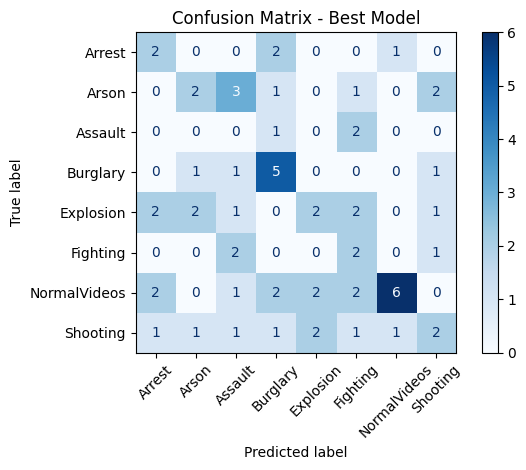

In [ ]:
# freeze all layers except classification head
for name, param in model.named_parameters():
    if 'cls_head' not in name:
        param.requires_grad = False


# : new optimizer for just the head
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)


# retrain classifier with same early stopping
best_test_auc = 0.0
patience, patience_counter = 3, 0


for epoch in range(1, 11):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()


        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())


    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    train_auc = roc_auc_score(
        F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )


    # eval
    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())


    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    test_auc = roc_auc_score(
        F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )


    print(f"[FT-Classifier] Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")


    if test_auc > best_test_auc:
        best_test_auc = test_auc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_finetuned_head.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered on classifier fine-tune.")
            break


#  confusion matrix for final predictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


model.load_state_dict(torch.load("best_model_finetuned_head.pt"))
model.eval()
final_preds, final_targets = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        final_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        final_targets.extend(batch_y.numpy())


cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Best Model")
plt.tight_layout()
plt.show()


# **Stage 7: Grid Search & Final Model Deployment**
(Hyperparameter tuning, retraining best model, multi-sequence final training)

In [ ]:
import itertools
import random
from copy import deepcopy
import pandas as pd


# hyperparameters
param_grid = {
    'sequence_length': [16, 32],
    'dropout': [0.3, 0.4],
    'hidden_dim': [128, 256],
    'num_layers': [1, 2],
    'lr': [1e-3, 1e-4]
}


# combintions
combinations = list(itertools.product(*param_grid.values()))
random.shuffle(combinations)  # fir diversity
combinations = combinations[:12]  #  12 configs
param_names = list(param_grid.keys())


#  logging metrics
logs = []
best_auc = 0
best_config = None


for i, combo in enumerate(combinations):
    config = dict(zip(param_names, combo))
    print(f"\n Config {i+1}/12: {config}")


    train_dataset.sequence_length = config['sequence_length']
    test_dataset.sequence_length = config['sequence_length']
    train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


    class GridVideoTransformer(nn.Module):
        def __init__(self, feature_dim, num_classes, sequence_length, dropout, hidden_dim, num_layers):
            super().__init__()
            self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))
            self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=feature_dim,
                    nhead=4,
                    dim_feedforward=512,
                    dropout=dropout,
                    activation='gelu',
                    batch_first=True,
                    norm_first=True
                ),
                num_layers=num_layers
            )
            self.cls_head = nn.Sequential(
                nn.LayerNorm([sequence_length, feature_dim]),
                nn.Flatten(),
                nn.Dropout(dropout),
                nn.Linear(feature_dim * sequence_length, hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )


        def forward(self, x):
            x = x + self.positional_encoding[:, :x.size(1), :]
            x = self.transformer(x)
            return self.cls_head(x)


    model = GridVideoTransformer(
        feature_dim=768,
        num_classes=len(CLASS_NAMES),
        sequence_length=config['sequence_length'],
        dropout=config['dropout'],
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers']
    ).to(device)


    optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-5)


    for epoch in range(3):
        model.train()
        train_loss, train_preds, train_targets = 0, [], []


        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
            loss.backward()
            optimizer.step()


            train_loss += loss.item() * batch_x.size(0)
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(batch_y.cpu().numpy())


        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_auc = roc_auc_score(
            F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
            F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
            multi_class='ovr'
        )


        model.eval()
        test_loss, test_preds, test_targets = 0, [], []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = F.cross_entropy(outputs, batch_y)
                test_loss += loss.item() * batch_x.size(0)
                test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                test_targets.extend(batch_y.cpu().numpy())


        test_loss /= len(test_loader.dataset)
        test_acc = accuracy_score(test_targets, test_preds)
        test_auc = roc_auc_score(
            F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
            F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
            multi_class='ovr'
        )


        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")


        logs.append({
            **config,
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_auc': train_auc,
            'test_loss': test_loss,
            'test_acc': test_acc,
            'test_auc': test_auc
        })


        if test_auc > best_auc:
            best_auc = test_auc
            best_config = deepcopy(config)
            torch.save(model.state_dict(), "best_grid_model.pt")


# saving
pd.DataFrame(logs).to_csv("grid_search_results.csv", index=False)
print("\n Best Config:", best_config)
print(f" Best AUC: {best_auc:.4f}")



 Config 1/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.5454, Acc: 0.1847, AUC: 0.5301 | Test Loss: 2.5469, Acc: 0.2000, AUC: 0.5293
[Epoch 2] Train Loss: 2.0586, Acc: 0.1289, AUC: 0.4955 | Test Loss: 2.0935, Acc: 0.0769, AUC: 0.4984
[Epoch 3] Train Loss: 2.0585, Acc: 0.1603, AUC: 0.5177 | Test Loss: 2.1122, Acc: 0.1385, AUC: 0.5352

 Config 2/15: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 1.9720, Acc: 0.2125, AUC: 0.5494 | Test Loss: 2.0269, Acc: 0.2308, AUC: 0.5517
[Epoch 2] Train Loss: 1.7208, Acc: 0.3240, AUC: 0.6129 | Test Loss: 2.0103, Acc: 0.2462, AUC: 0.5637
[Epoch 3] Train Loss: 1.3909, Acc: 0.4634, AUC: 0.7003 | Test Loss: 1.9795, Acc: 0.2923, AUC: 0.5706

 Config 3/15: {'sequence_length': 32, 'dropout': 0.3, 'hidden_dim': 256, 'num_layers': 2, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 4.6677, Acc: 0.1220, AUC: 0.4985 | Test Loss: 2.1617, Acc: 0.1231, AUC: 0.5000
[Epoch 2] Train Loss: 2.1293, Acc: 0.1080, AUC: 0.4956 | Test Loss: 2.0731, Acc: 0.1385, AUC: 0.5000
[Epoch 3] Train Loss: 2.0736, Acc: 0.1533, AUC: 0.5000 | Test Loss: 2.0763, Acc: 0.1385, AUC: 0.5000

 Config 4/15: {'sequence_length': 32, 'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 1.8777, Acc: 0.2927, AUC: 0.5798 | Test Loss: 2.0457, Acc: 0.2154, AUC: 0.5521
[Epoch 2] Train Loss: 1.4411, Acc: 0.4425, AUC: 0.6726 | Test Loss: 2.1539, Acc: 0.2308, AUC: 0.5619
[Epoch 3] Train Loss: 1.2387, Acc: 0.5192, AUC: 0.7218 | Test Loss: 2.1634, Acc: 0.2923, AUC: 0.5831

 Config 5/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 256, 'num_layers': 1, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 1.9656, Acc: 0.1986, AUC: 0.5376 | Test Loss: 2.2716, Acc: 0.1077, AUC: 0.4906
[Epoch 2] Train Loss: 1.7267, Acc: 0.3171, AUC: 0.6029 | Test Loss: 2.1070, Acc: 0.2462, AUC: 0.5742
[Epoch 3] Train Loss: 1.3768, Acc: 0.4739, AUC: 0.6917 | Test Loss: 1.9332, Acc: 0.3077, AUC: 0.6057

 Config 6/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0228, Acc: 0.1847, AUC: 0.5358 | Test Loss: 2.0949, Acc: 0.2308, AUC: 0.5663
[Epoch 2] Train Loss: 1.6965, Acc: 0.3310, AUC: 0.6135 | Test Loss: 2.2533, Acc: 0.1692, AUC: 0.5481
[Epoch 3] Train Loss: 1.3810, Acc: 0.4286, AUC: 0.6773 | Test Loss: 2.1622, Acc: 0.2000, AUC: 0.5206

 Config 7/15: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.9541, Acc: 0.1324, AUC: 0.5032 | Test Loss: 2.1308, Acc: 0.1538, AUC: 0.5000
[Epoch 2] Train Loss: 2.0663, Acc: 0.1359, AUC: 0.5032 | Test Loss: 2.6948, Acc: 0.1538, AUC: 0.5000
[Epoch 3] Train Loss: 2.1069, Acc: 0.1080, AUC: 0.4932 | Test Loss: 2.0766, Acc: 0.1538, AUC: 0.5000

 Config 8/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 256, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0873, Acc: 0.2544, AUC: 0.5690 | Test Loss: 2.3094, Acc: 0.2462, AUC: 0.5685
[Epoch 2] Train Loss: 1.7886, Acc: 0.2962, AUC: 0.5968 | Test Loss: 2.0748, Acc: 0.2462, AUC: 0.5693
[Epoch 3] Train Loss: 1.3943, Acc: 0.4460, AUC: 0.6907 | Test Loss: 1.9433, Acc: 0.3231, AUC: 0.6128

 Config 9/15: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 256, 'num_layers': 1, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 3.0263, Acc: 0.1359, AUC: 0.5055 | Test Loss: 2.2915, Acc: 0.1385, AUC: 0.5000
[Epoch 2] Train Loss: 2.0197, Acc: 0.2160, AUC: 0.5464 | Test Loss: 2.0936, Acc: 0.1538, AUC: 0.5221
[Epoch 3] Train Loss: 2.0923, Acc: 0.1707, AUC: 0.5188 | Test Loss: 2.1406, Acc: 0.0769, AUC: 0.5001

 Config 10/15: {'sequence_length': 32, 'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 3.9783, Acc: 0.1185, AUC: 0.4967 | Test Loss: 2.1797, Acc: 0.0769, AUC: 0.5000
[Epoch 2] Train Loss: 2.0913, Acc: 0.1080, AUC: 0.4879 | Test Loss: 2.0743, Acc: 0.1538, AUC: 0.5000
[Epoch 3] Train Loss: 2.0800, Acc: 0.1359, AUC: 0.5000 | Test Loss: 2.0765, Acc: 0.1538, AUC: 0.5000

 Config 11/15: {'sequence_length': 32, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0614, Acc: 0.2056, AUC: 0.5404 | Test Loss: 1.9628, Acc: 0.2462, AUC: 0.5516
[Epoch 2] Train Loss: 1.6601, Acc: 0.3449, AUC: 0.6190 | Test Loss: 1.8535, Acc: 0.2923, AUC: 0.5617
[Epoch 3] Train Loss: 1.4380, Acc: 0.3868, AUC: 0.6477 | Test Loss: 2.1727, Acc: 0.2000, AUC: 0.5720

 Config 12/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.5269, Acc: 0.1324, AUC: 0.5069 | Test Loss: 2.3590, Acc: 0.1385, AUC: 0.5003
[Epoch 2] Train Loss: 2.0258, Acc: 0.1672, AUC: 0.5198 | Test Loss: 2.1642, Acc: 0.2154, AUC: 0.5328
[Epoch 3] Train Loss: 1.9999, Acc: 0.1742, AUC: 0.5332 | Test Loss: 3.0083, Acc: 0.1231, AUC: 0.5044

 Config 13/15: {'sequence_length': 16, 'dropout': 0.3, 'hidden_dim': 256, 'num_layers': 2, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.1072, Acc: 0.1742, AUC: 0.5281 | Test Loss: 2.0831, Acc: 0.2154, AUC: 0.5351
[Epoch 2] Train Loss: 1.6045, Acc: 0.3659, AUC: 0.6334 | Test Loss: 2.0999, Acc: 0.2462, AUC: 0.5830
[Epoch 3] Train Loss: 1.2294, Acc: 0.5331, AUC: 0.7336 | Test Loss: 2.0045, Acc: 0.3692, AUC: 0.6134

 Config 14/15: {'sequence_length': 32, 'dropout': 0.3, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0278, Acc: 0.2369, AUC: 0.5472 | Test Loss: 1.8661, Acc: 0.3846, AUC: 0.6089
[Epoch 2] Train Loss: 1.6844, Acc: 0.3728, AUC: 0.6415 | Test Loss: 1.7811, Acc: 0.2000, AUC: 0.5287
[Epoch 3] Train Loss: 1.3857, Acc: 0.4913, AUC: 0.7147 | Test Loss: 1.8675, Acc: 0.2308, AUC: 0.5580

 Config 15/15: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.0001}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Epoch 1] Train Loss: 2.0369, Acc: 0.2160, AUC: 0.5506 | Test Loss: 2.0306, Acc: 0.2308, AUC: 0.5439
[Epoch 2] Train Loss: 1.7377, Acc: 0.3240, AUC: 0.6081 | Test Loss: 2.0628, Acc: 0.2000, AUC: 0.5317
[Epoch 3] Train Loss: 1.5074, Acc: 0.4077, AUC: 0.6613 | Test Loss: 1.8304, Acc: 0.3692, AUC: 0.6165

 Best Config: {'sequence_length': 16, 'dropout': 0.4, 'hidden_dim': 128, 'num_layers': 1, 'lr': 0.0001}
 Best AUC: 0.6165


# **Stage 8: Final Training with Best Configuration**
(Trained model using best config hyperparameters from grid search: sequence_length=16, dropout=0.4, hidden_dim=128, num_layers=1, lr=0.0001)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np


#  Best Config from Grid Search
BEST_CONFIG = {
    'sequence_length': 16,
    'dropout': 0.4,
    'hidden_dim': 128,
    'num_layers': 1,
    'lr': 0.0001
}




class FinalVideoTransformer(nn.Module):
    def __init__(self, feature_dim, num_classes, sequence_length, dropout, hidden_dim, num_layers):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=4,
                dim_feedforward=512,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=num_layers
        )
        self.cls_head = nn.Sequential(
            nn.LayerNorm([sequence_length, feature_dim]),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * sequence_length, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, len(CLASS_NAMES))
        )


    def forward(self, x):
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        return self.cls_head(x)




train_dataset.sequence_length = BEST_CONFIG['sequence_length']
test_dataset.sequence_length = BEST_CONFIG['sequence_length']


train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)




model = FinalVideoTransformer(
    feature_dim=768,
    num_classes=len(CLASS_NAMES),
    sequence_length=BEST_CONFIG['sequence_length'],
    dropout=BEST_CONFIG['dropout'],
    hidden_dim=BEST_CONFIG['hidden_dim'],
    num_layers=BEST_CONFIG['num_layers']
).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=BEST_CONFIG['lr'], weight_decay=1e-5)


# Training Loop
best_auc = 0
patience = 3
wait = 0


print("\n training \n")


for epoch in range(15):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []


    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = F.cross_entropy(outputs, batch_y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()


        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())


    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    train_auc = roc_auc_score(
        F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )



    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = F.cross_entropy(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())


    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    test_auc = roc_auc_score(
        F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )


    print(f"[Epoch {epoch+1:02d}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")


    #  early Stopping
    if test_auc > best_auc:
        best_auc = test_auc
        wait = 0
        torch.save(model.state_dict(), "final_best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break




/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



 training 

[Epoch 01] Train Loss: 2.1237, Acc: 0.1742, AUC: 0.5224 | Test Loss: 2.0002, Acc: 0.2000, AUC: 0.5241
[Epoch 02] Train Loss: 1.7859, Acc: 0.2718, AUC: 0.5794 | Test Loss: 1.9926, Acc: 0.1846, AUC: 0.5386
[Epoch 03] Train Loss: 1.6862, Acc: 0.3345, AUC: 0.6171 | Test Loss: 1.9808, Acc: 0.2615, AUC: 0.5731
[Epoch 04] Train Loss: 1.4179, Acc: 0.4321, AUC: 0.6751 | Test Loss: 2.0212, Acc: 0.2308, AUC: 0.5444
[Epoch 05] Train Loss: 1.3185, Acc: 0.4739, AUC: 0.7043 | Test Loss: 1.9310, Acc: 0.2923, AUC: 0.5736
[Epoch 06] Train Loss: 1.1035, Acc: 0.5784, AUC: 0.7497 | Test Loss: 2.0374, Acc: 0.3077, AUC: 0.5928
[Epoch 07] Train Loss: 0.9893, Acc: 0.5784, AUC: 0.7524 | Test Loss: 2.0204, Acc: 0.3077, AUC: 0.6054
[Epoch 08] Train Loss: 0.9554, Acc: 0.6272, AUC: 0.7941 | Test Loss: 1.9083, Acc: 0.2923, AUC: 0.5830
[Epoch 09] Train Loss: 0.8524, Acc: 0.6969, AUC: 0.8306 | Test Loss: 1.8690, Acc: 0.3385, AUC: 0.6051
[Epoch 10] Train Loss: 0.6609, Acc: 0.7526, AUC: 0.8532 | Test Loss: 

In [ ]:
!pip install wandb

# **Stage 9: Multi-Sequence Model Training**
(Created a new dataset class to extract up to 10 sequences per video using stride=12, resize frames to 224×224, extract features with DINOv2, and prepare dataloaders for final training)

In [ ]:
import wandb
wandb.login()
from torch.utils.data import Dataset
from PIL import Image
from transformers import AutoImageProcessor, AutoModel
import torch
import os
from glob import glob


class VideoDatasetClass2(Dataset):
    def __init__(self, base_dir, label_encoder, sequence_length=16, image_size=224, stride=12):
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.samples = []
        self.label_encoder = label_encoder


        self.processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
        self.dinov2 = AutoModel.from_pretrained("facebook/dinov2-base").eval().to("cuda")


        for class_name in os.listdir(base_dir):
            class_path = os.path.join(base_dir, class_name)
            if not os.path.isdir(class_path): continue


            for video_folder in os.listdir(class_path):
                video_path = os.path.join(class_path, video_folder)
                frame_paths = sorted(glob(os.path.join(video_path, '*.png')))
                label = self.label_encoder.transform([class_name])[0]


                # create sequences with stride
                sequences = []
                for i in range(0, len(frame_paths) - sequence_length + 1, stride):
                    clip = frame_paths[i:i + sequence_length]
                    if len(clip) == sequence_length:
                        sequences.append((clip, label))


                sequences = sequences[:10]  # cap to 10 per video
                self.samples.extend(sequences)


        print(f"total sequences: {len(self.samples)}")


    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        paths, label = self.samples[idx]
        images = [Image.open(p).convert("RGB").resize((self.image_size, self.image_size)) for p in paths]
        inputs = self.processor(images=images, return_tensors="pt").to("cuda")


        with torch.no_grad():
            features = self.dinov2(**inputs).last_hidden_state.mean(dim=1)  # [sequence_length, 768]


        return features.cpu(), torch.tensor(label)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: marium-waseem (marium-waseem-city-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
label_encoder.fit(CLASS_NAMES)



LabelEncoder()

In [ ]:
from torch.utils.data import DataLoader


train_dataset = VideoDatasetClass2(
    base_dir="data_trimmed_restructured/Train",
    label_encoder=label_encoder,
    sequence_length=16,
    image_size=224,
    stride=12
)


test_dataset = VideoDatasetClass2(
    base_dir="data_trimmed_restructured/Test",
    label_encoder=label_encoder,
    sequence_length=16,
    image_size=224,
    stride=12
)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

total sequences: 2531
total sequences: 607


# **Stage 10: Final Model Training & Logging**
(Defined final Transformer model with best config, applied label smoothing for stable learning, and logged training with Weights & Biases)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score


# config
BEST_CONFIG = {
    'sequence_length': 16,
    'dropout': 0.4,
    'hidden_dim': 128,
    'num_layers': 1,
    'lr': 0.0001
}


# model
class FinalVideoTransformer2(nn.Module):
    def __init__(self, feature_dim, num_classes, sequence_length, dropout, hidden_dim, num_layers):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_length, feature_dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_dim,
                nhead=4,
                dim_feedforward=512,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=num_layers
        )
        self.cls_head = nn.Sequential(
            nn.LayerNorm([sequence_length, feature_dim]),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim * sequence_length, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, len(CLASS_NAMES))
        )


    def forward(self, x):
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        return self.cls_head(x)


In [ ]:
import wandb
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score

# config
BEST_CONFIG = {
    'sequence_length': 16,
    'dropout': 0.4,
    'hidden_dim': 128,
    'num_layers': 1,
    'lr': 0.0001
}

wandb.init(project="video-anomaly-detection", name="final-dinov2-multiseq-smoothing")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FinalVideoTransformer2(
    feature_dim=768,
    num_classes=len(CLASS_NAMES),
    sequence_length=BEST_CONFIG['sequence_length'],
    dropout=BEST_CONFIG['dropout'],
    hidden_dim=BEST_CONFIG['hidden_dim'],
    num_layers=BEST_CONFIG['num_layers']
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=BEST_CONFIG['lr'], weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)  # label smoothing added

print("\ntraining begins\n")

for epoch in range(30):
    start_time = time.time()
    model.train()
    train_loss, train_preds, train_targets = 0, [], []

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    train_auc = roc_auc_score(
        F.one_hot(torch.tensor(train_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(train_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )

    model.eval()
    test_loss, test_preds, test_targets = 0, [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    test_auc = roc_auc_score(
        F.one_hot(torch.tensor(test_targets), num_classes=len(CLASS_NAMES)),
        F.one_hot(torch.tensor(test_preds), num_classes=len(CLASS_NAMES)),
        multi_class='ovr'
    )

    print(f"[epoch {epoch+1:02d}] train loss: {train_loss:.4f}, acc: {train_acc:.4f}, auc: {train_auc:.4f} | "
          f"test loss: {test_loss:.4f}, acc: {test_acc:.4f}, auc: {test_auc:.4f}")

    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_acc,
        'train_auc': train_auc,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_auc': test_auc
    })

torch.save(model.state_dict(), "final_best_model_dinov2_multiseq.pt")
print(f"epoch {epoch+1} take {time.time() - start_time:.2f} seconds")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



training begins

[epoch 01] train loss: 1.5675, acc: 0.4836, auc: 0.6617 | test loss: 1.8586, acc: 0.4020, auc: 0.6359
[epoch 02] train loss: 1.0247, acc: 0.7740, auc: 0.8479 | test loss: 2.3584, acc: 0.2900, auc: 0.5814
[epoch 03] train loss: 0.7675, acc: 0.9111, auc: 0.9412 | test loss: 2.6803, acc: 0.2998, auc: 0.5870
[epoch 04] train loss: 0.6688, acc: 0.9644, auc: 0.9771 | test loss: 2.3395, acc: 0.3476, auc: 0.6146
[epoch 05] train loss: 0.6188, acc: 0.9842, auc: 0.9895 | test loss: 2.3125, acc: 0.3558, auc: 0.6191
[epoch 06] train loss: 0.5905, acc: 0.9933, auc: 0.9949 | test loss: 2.3830, acc: 0.3460, auc: 0.6168
[epoch 07] train loss: 0.5774, acc: 0.9957, auc: 0.9968 | test loss: 2.3900, acc: 0.3410, auc: 0.6045
[epoch 08] train loss: 0.5720, acc: 0.9941, auc: 0.9958 | test loss: 2.4604, acc: 0.3427, auc: 0.6027
[epoch 09] train loss: 0.5685, acc: 0.9957, auc: 0.9972 | test loss: 2.3812, acc: 0.3328, auc: 0.6016
[epoch 10] train loss: 0.5519, acc: 0.9988, auc: 0.9994 | test l